In [241]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import boto3
from IPython.display import Audio
from scipy.io import wavfile
from pydub import AudioSegment
import soundfile as sf
from io import BytesIO
from pyAudioAnalysis import audioBasicIO, ShortTermFeatures, MidTermFeatures
import audiosegment

import librosa
# from pyAudioAnalysis import ShortTermFeatures

In [3]:
s3_connection = boto3.resource('s3')
s3_client = boto3.client('s3')

In [4]:
bucket_name = 'jarednewstudy'

In [135]:
file_name = 'FSDKaggle2019.audio_train_curated/1a94671f.wav'

In [125]:
response = s3_client.get_object(Bucket=bucket_name,
                                 Key=file_name)

In [126]:
#using soundfile module

response = s3_client.get_object(Bucket=bucket_name,
                                 Key=file_name,
                                )

data = BytesIO(response['Body'].read())
sound, samplerate = sf.read(data)
Audio(data=sound, rate=samplerate)

In [59]:
# using AudioSegment module
response = s3_client.get_object(Bucket=bucket_name,
                                 Key=file_name,
                                )
data = BytesIO(response['Body'].read())
seg = AudioSegment.from_wav(data)

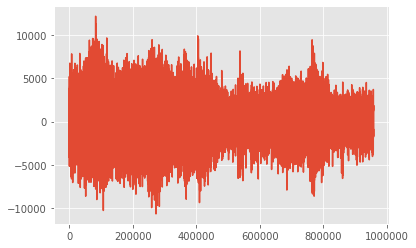

In [60]:
sample_array = seg.get_array_of_samples()
fig, ax = plt.subplots()

plt.plot(sample_array)

In [23]:
# using audiosegment module (wrapper for AudioSegment)

In [43]:
sample_conv = np.frombuffer(sample_array)

In [136]:
obj = s3_connection.Object(bucket_name, key=file_name)
result = obj.get()['Body'].read()
wrapper = BytesIO(result)
wav_ = wavfile.read(wrapper)
seg = audiosegment.from_numpy_array(wav_[1], wav_[0])

Text(0, 0.5, 'Frequency in Hz')

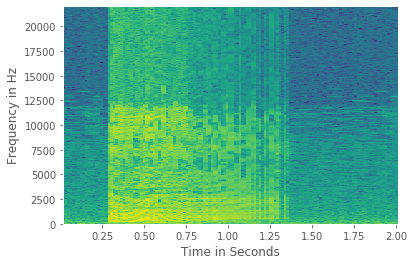

In [139]:
#...
freqs, times, amplitudes = seg.spectrogram(window_length_s=0.03, overlap=0.5)
amplitudes = 10 * np.log10(amplitudes + 1e-9)

# Plot
plt.pcolormesh(times, freqs, amplitudes)
plt.xlabel("Time in Seconds")
plt.ylabel("Frequency in Hz")



Text(0, 0.5, 'energy')

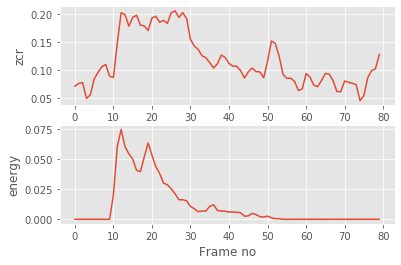

In [219]:
#short term feature extraction

obj = s3_connection.Object(bucket_name, key=file_name)
result = obj.get()['Body'].read()
wrapper = BytesIO(result)
wav_ = wavfile.read(wrapper)


Fs, x = wav_[0], wav_[1]
F, f_names = ShortTermFeatures.feature_extraction(x, Fs, 0.050*Fs, 0.025*Fs)
plt.subplot(2,1,1); plt.plot(F[0,:]); plt.xlabel('Frame no'); plt.ylabel(f_names[0]) 
plt.subplot(2,1,2); plt.plot(F[1,:]); plt.xlabel('Frame no'); plt.ylabel(f_names[1])

In [240]:
f_names

['zcr',
 'energy',
 'energy_entropy',
 'spectral_centroid',
 'spectral_spread',
 'spectral_entropy',
 'spectral_flux',
 'spectral_rolloff',
 'mfcc_1',
 'mfcc_2',
 'mfcc_3',
 'mfcc_4',
 'mfcc_5',
 'mfcc_6',
 'mfcc_7',
 'mfcc_8',
 'mfcc_9',
 'mfcc_10',
 'mfcc_11',
 'mfcc_12',
 'mfcc_13',
 'chroma_1',
 'chroma_2',
 'chroma_3',
 'chroma_4',
 'chroma_5',
 'chroma_6',
 'chroma_7',
 'chroma_8',
 'chroma_9',
 'chroma_10',
 'chroma_11',
 'chroma_12',
 'chroma_std',
 'delta zcr',
 'delta energy',
 'delta energy_entropy',
 'delta spectral_centroid',
 'delta spectral_spread',
 'delta spectral_entropy',
 'delta spectral_flux',
 'delta spectral_rolloff',
 'delta mfcc_1',
 'delta mfcc_2',
 'delta mfcc_3',
 'delta mfcc_4',
 'delta mfcc_5',
 'delta mfcc_6',
 'delta mfcc_7',
 'delta mfcc_8',
 'delta mfcc_9',
 'delta mfcc_10',
 'delta mfcc_11',
 'delta mfcc_12',
 'delta mfcc_13',
 'delta chroma_1',
 'delta chroma_2',
 'delta chroma_3',
 'delta chroma_4',
 'delta chroma_5',
 'delta chroma_6',
 'delta chro

Text(0, 0.5, 'energy_mean')

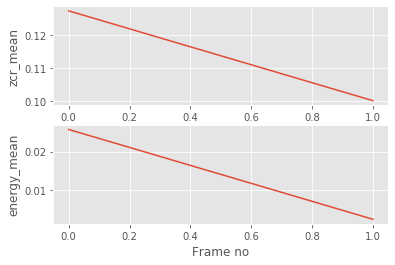

In [238]:
# MidTerm feature extraction

obj = s3_connection.Object(bucket_name, key=file_name)
result = obj.get()['Body'].read()
wrapper = BytesIO(result)
wav_ = wavfile.read(wrapper)


Fs, x = wav_[0], wav_[1]
Mid_F, Short_F, mid_f_names = MidTermFeatures.mid_feature_extraction(signal=x,
                                                    sampling_rate=Fs, 
                                                    mid_window=0.5*Fs,
                                                    mid_step =Fs,
                                                    short_window = 0.050*Fs,
                                                    short_step = 0.025*Fs)
plt.subplot(2,1,1); plt.plot(Mid_F[0,:]); plt.xlabel('Frame no'); plt.ylabel(mid_f_names[0]) 
plt.subplot(2,1,2); plt.plot(Mid_F[1,:]); plt.xlabel('Frame no'); plt.ylabel(mid_f_names[1])


In [233]:
Mid_F

array([[ 1.16991833e-01,  9.05058984e-02],
       [ 1.16800790e-02,  1.21391723e-03],
       [ 2.60264983e+00,  2.54189946e+00],
       [ 2.00733479e-01,  1.80144779e-01],
       [ 2.05745031e-01,  1.96495194e-01],
       [ 1.07229968e+00,  9.17085878e-01],
       [ 1.68191788e-03,  1.85304828e-03],
       [ 2.21324864e-01,  1.44600726e-01],
       [-2.67484908e+01, -2.90130478e+01],
       [ 9.94943092e-01,  1.10087607e+00],
       [-4.02474781e-01, -5.96090998e-02],
       [ 9.77299094e-02,  2.51227178e-01],
       [-2.11336763e-02,  1.10612400e-01],
       [ 1.27019776e-01,  2.19522121e-01],
       [-5.42949451e-02, -9.92596012e-03],
       [ 9.41749957e-02,  4.69798855e-02],
       [-1.30534750e-01, -1.65055791e-01],
       [ 7.38872779e-02,  3.94083439e-02],
       [-4.15892420e-02,  5.51385540e-02],
       [ 4.87659812e-02,  7.55670832e-02],
       [ 2.47626038e-02,  2.30935467e-02],
       [ 1.08596661e-02,  1.12174665e-02],
       [ 5.07290694e-03,  3.17667184e-03],
       [ 3.

In [235]:
mid_f_names

['zcr_mean',
 'energy_mean',
 'energy_entropy_mean',
 'spectral_centroid_mean',
 'spectral_spread_mean',
 'spectral_entropy_mean',
 'spectral_flux_mean',
 'spectral_rolloff_mean',
 'mfcc_1_mean',
 'mfcc_2_mean',
 'mfcc_3_mean',
 'mfcc_4_mean',
 'mfcc_5_mean',
 'mfcc_6_mean',
 'mfcc_7_mean',
 'mfcc_8_mean',
 'mfcc_9_mean',
 'mfcc_10_mean',
 'mfcc_11_mean',
 'mfcc_12_mean',
 'mfcc_13_mean',
 'chroma_1_mean',
 'chroma_2_mean',
 'chroma_3_mean',
 'chroma_4_mean',
 'chroma_5_mean',
 'chroma_6_mean',
 'chroma_7_mean',
 'chroma_8_mean',
 'chroma_9_mean',
 'chroma_10_mean',
 'chroma_11_mean',
 'chroma_12_mean',
 'chroma_std_mean',
 'delta zcr_mean',
 'delta energy_mean',
 'delta energy_entropy_mean',
 'delta spectral_centroid_mean',
 'delta spectral_spread_mean',
 'delta spectral_entropy_mean',
 'delta spectral_flux_mean',
 'delta spectral_rolloff_mean',
 'delta mfcc_1_mean',
 'delta mfcc_2_mean',
 'delta mfcc_3_mean',
 'delta mfcc_4_mean',
 'delta mfcc_5_mean',
 'delta mfcc_6_mean',
 'delta m

In [186]:
# Each row in F is a different feature for a signal. The columns are time "blocks"... normazlied
# f_names is a list of feature names
len(f_names)

68

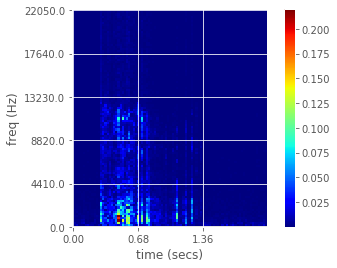

In [189]:
_ = ShortTermFeatures.spectrogram(x, Fs, window=200, step=1000, plot=True)

## Combining the work asbove into iterable functions

At a top level, iteratinging over the S3 bucket,
calling a function on each object that will create and store features into a database.
Need to include a file name as index or column, to allow a join later to labels csv

In [161]:
def feature_extract(obj):
    result = obj.get()['Body'].read()
    wrapper = BytesIO(result)
    wav_ = wavfile.read(wrapper)
    Fs, x = wav_[0], wav_[1]
    Mid_F, Short_F, mid_f_names = MidTermFeatures.mid_feature_extraction(signal=x,
                                                    sampling_rate=Fs, 
                                                    mid_window = 0.5*Fs,
                                                    mid_step = 0.25*Fs,
                                                    short_window = 0.050*Fs,
                                                    short_step = 0.025*Fs)
    return F, f_names

In [212]:
def process_s3(client, bucket_name):
    
    audio_mat = []
    features = []
    file_names = []
    #iterate 
    paginator = client.get_paginator('list_objects_v2')
    result = paginator.paginate(Bucket=bucket_name)
    for page in result:
        if "Contents" in page:
            for key in page[ "Contents" ][1:3]:
                keyString = key[ "Key" ]
                name = keyString.split('/')[-1]
                file_names.append(name)
                print (name)
                obj = s3_connection.Object(bucket_name, key=keyString)
                F, f_names = feature_extract(obj)
                audio_mat.append(F)
                if not features:
                    features = [f for f in f_names]
                
    return audio_mat, features, file_names

In [239]:
audio_mat, feature_list, file_names = process_s3(s3_client, bucket_name)

0006ae4e.wav
0019ef41.wav
3467e392.wav
3469acad.wav
67124738.wav
671ec56c.wav
9bc49e29.wav
9bc54fb2.wav
ce3a426e.wav
ce3cae38.wav


In [214]:
audio_mat

[array([[ 6.94192377e-02,  3.72050817e-02,  3.13067151e-02, ...,
          2.72232305e-03,  3.17604356e-03,  9.52813067e-03],
        [ 8.64675841e-06,  3.26656988e-05,  9.82498355e-05, ...,
          1.38408008e-04,  8.01491176e-05,  3.21227587e-05],
        [ 2.74941716e+00,  2.83588751e+00,  2.84003070e+00, ...,
          2.95665109e+00,  2.79741827e+00,  2.71098097e+00],
        ...,
        [ 0.00000000e+00,  5.21770941e-02, -1.12828180e-01, ...,
         -1.91064319e-02, -3.58890253e-03,  2.25977417e-03],
        [ 0.00000000e+00,  2.89391389e-04, -2.30870550e-04, ...,
         -5.07884725e-04,  1.48154869e-04,  5.62964320e-06],
        [ 0.00000000e+00,  7.93490872e-03,  1.00329276e-02, ...,
         -1.54534991e-02,  3.63849900e-02, -1.36218455e-02]]),
 array([[ 2.94918330e-01,  1.35208711e-01,  1.12522686e-01, ...,
          1.06624319e-01,  1.09800363e-01,  1.10707804e-01],
        [ 2.30824911e-03,  7.16647959e-05,  7.15945980e-05, ...,
          1.11229450e-06,  1.63986754e

In [181]:
feature_list

['zcr',
 'energy',
 'energy_entropy',
 'spectral_centroid',
 'spectral_spread',
 'spectral_entropy',
 'spectral_flux',
 'spectral_rolloff',
 'mfcc_1',
 'mfcc_2',
 'mfcc_3',
 'mfcc_4',
 'mfcc_5',
 'mfcc_6',
 'mfcc_7',
 'mfcc_8',
 'mfcc_9',
 'mfcc_10',
 'mfcc_11',
 'mfcc_12',
 'mfcc_13',
 'chroma_1',
 'chroma_2',
 'chroma_3',
 'chroma_4',
 'chroma_5',
 'chroma_6',
 'chroma_7',
 'chroma_8',
 'chroma_9',
 'chroma_10',
 'chroma_11',
 'chroma_12',
 'chroma_std',
 'delta zcr',
 'delta energy',
 'delta energy_entropy',
 'delta spectral_centroid',
 'delta spectral_spread',
 'delta spectral_entropy',
 'delta spectral_flux',
 'delta spectral_rolloff',
 'delta mfcc_1',
 'delta mfcc_2',
 'delta mfcc_3',
 'delta mfcc_4',
 'delta mfcc_5',
 'delta mfcc_6',
 'delta mfcc_7',
 'delta mfcc_8',
 'delta mfcc_9',
 'delta mfcc_10',
 'delta mfcc_11',
 'delta mfcc_12',
 'delta mfcc_13',
 'delta chroma_1',
 'delta chroma_2',
 'delta chroma_3',
 'delta chroma_4',
 'delta chroma_5',
 'delta chroma_6',
 'delta chro

In [242]:
#focus just on mfcc

In [215]:
file_names

['0006ae4e.wav',
 '0019ef41.wav',
 '3467e392.wav',
 '3469acad.wav',
 '67124738.wav',
 '671ec56c.wav',
 '9bc49e29.wav',
 '9bc54fb2.wav',
 'ce3a426e.wav',
 'ce3cae38.wav']

In [200]:
len(audio_mat[4][0])

1124

In [216]:
df = pd.DataFrame(columns=feature_list, index = file_names, data = audio_mat)

ValueError: Shape of passed values is (10, 1), indices imply (10, 68)

In [244]:
response = s3_client.get_object(Bucket=bucket_name,
                                 Key=file_name,
                                )


data = BytesIO(response['Body'].read())
# sound, samplerate = sf.read(data)
y, sr = librosa.load(data, mono=True, duration=3, offset = .5)
mfcc = librosa.feature.mfcc(y=y, sr=sr)

In [246]:
mfcc.shape

(20, 66)